In [1]:
# Standard, safe imports used throughout the notebook (only after checks above)
import warnings
import os

warnings.filterwarnings('ignore')
os.environ['OPENCV_LOG_LEVEL'] = 'SILENT'  # Suppress libpng ICC warnings

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import cv2  # safe to reference; if broken earlier the message above explains
import random
from tqdm import tqdm
from pathlib import Path

# kagglehub: keep stub if missing
try:
    import kagglehub
except Exception:
    class _KaggleHubStub:
        def dataset_download(self, *args, **kwargs):
            raise ModuleNotFoundError("kagglehub is not installed. Install it or set BASE_PATH manually.")
    kagglehub = _KaggleHubStub()


def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)
print("✅ Dependency checks complete (no installs were performed)")

✅ Dependency checks complete (no installs were performed)


In [2]:
# ============================================
# 📁 Step 2: Download and Load Dataset
# ============================================

# Specify your custom folder path here
CUSTOM_DATA_PATH = "datasets"  # Change this to your desired folder

# Create the folder if it doesn't exist
os.makedirs(CUSTOM_DATA_PATH, exist_ok=True)

# Set kagglehub cache directory to custom path
os.environ['KAGGLEHUB_HOME'] = CUSTOM_DATA_PATH

# Download dataset to custom folder (kagglehub will cache it in KAGGLEHUB_HOME)
path = kagglehub.dataset_download("khanfashee/nih-chest-x-ray-14-224x224-resized")
BASE_PATH = Path(path)

df = pd.read_csv(BASE_PATH / "Data_Entry_2017.csv")
images_dir = BASE_PATH / "images-224" / "images-224"
df["Image Path"] = [str(images_dir / p) for p in df["Image Index"].values]

DISEASE_CATEGORIES = [
    'Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass',
    'Nodule', 'Pneumonia', 'Pneumothorax', 'Consolidation', 'Edema',
    'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia'
]

for disease in DISEASE_CATEGORIES:
    df[disease] = df['Finding Labels'].apply(lambda x: 1 if disease in x else 0)

sample_paths = df['Image Path'].sample(200, random_state=42).values
missing = [p for p in sample_paths if not os.path.exists(p)]
if missing:
    raise FileNotFoundError(f"❌ Missing {len(missing)} images!")

print(f"✅ Dataset cache folder: {CUSTOM_DATA_PATH}")
print(f"✅ Dataset loaded from: {BASE_PATH}")
print(f"✅ Loaded {len(df):,} images")

✅ Dataset cache folder: datasets
✅ Dataset loaded from: /root/.cache/kagglehub/datasets/khanfashee/nih-chest-x-ray-14-224x224-resized/versions/3
✅ Loaded 112,120 images


In [3]:
# Cropping parameters
crop_padding = 1  # NEGATIVE = expand crop (add context), POSITIVE = shrink crop
min_crop_ratio = 0.5

# Configuration class

class Config:
    img_size = 224
    # Encoder backbone selection

    feat_dim = 256
    proj_dim = 128
    
    batch_size = 64  # Reduced from 64 to avoid OOM
    pretrain_epochs = 25
    finetune_epochs = 30
    lr_pretrain = 1e-3
    lr_finetune = 1e-4
    temperature = 0.1
    pathology_weight = 0.5
    
    # Auto-detect: use half of available CPUs (capped at 8)
    num_workers = min(os.cpu_count() // 2, 8)
    cache_masks = True   # Pre-load masks into RAM (faster training)
    use_subset = False
    
    # Adaptive thresholding params (as per documentation)
    adaptive_block_size = 51  # Block size for adaptive thresholding
    adaptive_C = 10           # Constant subtracted from weighted mean
    gradient_threshold = 0.1  # Threshold for gradient magnitude

    crop_padding = crop_padding
    min_crop_ratio = min_crop_ratio
    
    device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

cfg = Config()

print(f"✓ Config: img_size={cfg.img_size}, crop_padding={cfg.crop_padding}px, device={cfg.device}")

✓ Config: img_size=224, crop_padding=1px, device=cuda:1


In [4]:
# ============================================
# 💾 Step 3.5: Checkpoint & Resume Configuration
# ============================================

import os
import shutil
from datetime import datetime

OPTION_NAME = "option4"

# ===== RESUME CONFIGURATION =====
CHECKPOINT_DATASET_NAME = f"{OPTION_NAME}-ssl-checkpoints"  # Unique for Option 4
RESUME_SSL_PRETRAINING = True
RESUME_FINETUNING = True
SSL_CHECKPOINT_FILE = "latest"
FINETUNE_CHECKPOINT_FILE = "latest"

IN_KAGGLE = os.path.exists('/kaggle')
IN_COLAB = False

try:
    from google.colab import drive
    drive.mount('/content/drive')
    CHECKPOINT_DIR = '/content/drive/MyDrive/chest_xray_ssl'
    IN_COLAB = True
except:
    pass

if IN_KAGGLE:
    CHECKPOINT_DIR = '/kaggle/working/checkpoints'
    os.makedirs(CHECKPOINT_DIR, exist_ok=True)
    
    # Load checkpoints from ALL versions of the dataset (v1, v2, v3, etc.)
    input_path = '/kaggle/input'
    if os.path.exists(input_path):
        found_any = False
        for dataset_folder in sorted(os.listdir(input_path)):
            if dataset_folder.startswith(CHECKPOINT_DATASET_NAME):
                dataset_path = os.path.join(input_path, dataset_folder)
                if os.path.isdir(dataset_path):
                    # Check for .pth files in multiple locations:
                    # 1. Directly in dataset folder
                    # 2. In 'checkpoints' subdirectory
                    # 3. In any subdirectory
                    search_paths = [dataset_path]
                    
                    # Add checkpoints subdirectory if it exists
                    checkpoints_subdir = os.path.join(dataset_path, 'checkpoints')
                    if os.path.isdir(checkpoints_subdir):
                        search_paths.append(checkpoints_subdir)
                    
                    # Also check any other subdirectories for .pth files
                    for item in os.listdir(dataset_path):
                        item_path = os.path.join(dataset_path, item)
                        if os.path.isdir(item_path) and item != 'checkpoints':
                            search_paths.append(item_path)
                    
                    for search_path in search_paths:
                        pth_files = [f for f in os.listdir(search_path) if f.endswith('.pth')]
                        if pth_files:
                            found_any = True
                            rel_path = os.path.relpath(search_path, input_path)
                            print(f"📂 Found checkpoints in: {rel_path}")
                            for f in pth_files:
                                src = os.path.join(search_path, f)
                                dst = os.path.join(CHECKPOINT_DIR, f)
                                if not os.path.exists(dst):
                                    shutil.copy2(src, dst)
                                    print(f"   📦 Copied: {f}")
                                else:
                                    src_time = os.path.getmtime(src)
                                    dst_time = os.path.getmtime(dst)
                                    if src_time > dst_time:
                                        shutil.copy2(src, dst)
                                        print(f"   🔄 Updated: {f} (newer version)")
        
        if not found_any:
            print(f"ℹ️ No checkpoint datasets found matching: {CHECKPOINT_DATASET_NAME}*")
    
    existing = [f for f in os.listdir(CHECKPOINT_DIR) if f.endswith('.pth')]
    if existing:
        print(f"✅ Total checkpoints available: {len(existing)}")
    else:
        print(f"ℹ️ Starting fresh - no checkpoints loaded")
        
elif not IN_COLAB:
    CHECKPOINT_DIR = './checkpoints'

os.makedirs(CHECKPOINT_DIR, exist_ok=True)

def save_checkpoint(state, filename):
    filepath = os.path.join(CHECKPOINT_DIR, filename)
    state['saved_at'] = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    torch.save(state, filepath)
    print(f"💾 Saved: {filename}")
    if IN_KAGGLE: torch.save(state, f'/kaggle/working/{filename}')

def load_checkpoint(filename):
    filepath = os.path.join(CHECKPOINT_DIR, filename)
    if os.path.exists(filepath):
        # checkpoint = torch.load(filepath, map_location=cfg.device, weights_only=False)
        checkpoint = torch.load(filepath, map_location=cfg.device, weights_only=False)
        print(f"✅ Loaded: {filename}")
        return checkpoint
    return None

def find_latest_checkpoint(prefix):
    if not os.path.exists(CHECKPOINT_DIR): return None
    latest = f'{prefix}_latest.pth'
    if os.path.exists(os.path.join(CHECKPOINT_DIR, latest)): return latest
    import re
    pattern = re.compile(rf'{prefix}_epoch(\d+)\.pth')
    max_epoch, best = -1, None
    for f in os.listdir(CHECKPOINT_DIR):
        m = pattern.match(f)
        if m and int(m.group(1)) > max_epoch: max_epoch, best = int(m.group(1)), f
    return best

print(f"🔧 Environment: {'Kaggle' if IN_KAGGLE else 'Colab' if IN_COLAB else 'Local'}")
print(f"📂 Checkpoint dir: {CHECKPOINT_DIR}")

🔧 Environment: Local
📂 Checkpoint dir: ./checkpoints


In [5]:
def get_lung_bounding_box(mask):
    """Get bounding box of lung fields from mask
    
    Args:
        mask: Binary mask (0-1 float or 0-255 uint8)
    
    Returns:
        Tuple of (y_min, y_max, x_min, x_max) or None if no lung pixels found
    """
    coords = np.argwhere(mask > 0.5)
    
    if len(coords) == 0:
        return None
    
    y_min, x_min = coords.min(axis=0)
    y_max, x_max = coords.max(axis=0)
    
    return y_min, y_max, x_min, x_max


def context_aware_crop(image, mask, padding=-20, min_crop_ratio=0.5):
    """
    Crop image to lung bounding box with padding
    Preserves anatomical context while removing irrelevant background
    
    Args:
        image: Input image
        mask: Lung mask
        padding: Padding around bounding box (NEGATIVE = expand/add context, POSITIVE = shrink/focus)
        min_crop_ratio: Minimum crop size ratio to avoid over-cropping
    
    Returns:
        Cropped image and mask
    """
    bbox = get_lung_bounding_box(mask)
    
    if bbox is None:
        return image, mask
    
    y_min, y_max, x_min, x_max = bbox
    h, w = image.shape
    
    # Apply padding: negative values expand (add context), positive values shrink (focus)
    y_min = max(0, y_min + padding)  # +negative = move up, +positive = move down
    x_min = max(0, x_min + padding)  # +negative = move left, +positive = move right
    y_max = min(h, y_max - padding)  # -negative = move down, -positive = move up
    x_max = min(w, x_max - padding)  # -negative = move right, -positive = move left
    
    crop_h = y_max - y_min
    crop_w = x_max - x_min
    
    if crop_h < h * min_crop_ratio or crop_w < w * min_crop_ratio:
        return image, mask
    
    img_cropped = image[y_min:y_max, x_min:x_max]
    mask_cropped = mask[y_min:y_max, x_min:x_max]
    return img_cropped, mask_cropped

print("✅ Lung segmentation & cropping functions defined")

✅ Lung segmentation & cropping functions defined


In [6]:
# ============================================
# Note: Segmentation Parameters
# ============================================
# Lung segmentation is now handled by precompute_lung_masks.ipynb
# Pre-computed masks are loaded from lung_masks/pixel_masks/ in Step 4 above.
# To tune segmentation parameters, edit SegConfig in precompute_lung_masks.ipynb
# and re-run that notebook to regenerate the masks.

print("Segmentation parameters managed by precompute_lung_masks.ipynb")


Segmentation parameters managed by precompute_lung_masks.ipynb


In [7]:
# ============================================
# Step 4: Load Pre-Computed Lung Masks
# ============================================
# Masks pre-computed by precompute_lung_masks.ipynb
# Replaces segment_lungs_tunable(), segment_lungs_advanced(), segment_lungs()

if IN_KAGGLE:
    PIXEL_MASK_DIR = "/kaggle/working/lung_masks/pixel_masks"
elif IN_COLAB:
    PIXEL_MASK_DIR = "/content/drive/MyDrive/lung_masks/pixel_masks"
else:
    PIXEL_MASK_DIR = "./lung_masks/pixel_masks"

def load_precomputed_mask(img_name, mask_dir=PIXEL_MASK_DIR, img_size=224):
    """Load pre-computed pixel-level lung mask from disk."""
    mask_name = img_name.replace(".png", "")
    mask = np.load(os.path.join(mask_dir, f"{mask_name}.npy"))
    if mask.dtype == np.uint8:
        mask = mask.astype(np.float32) / 255.0
    if mask.shape[0] != img_size or mask.shape[1] != img_size:
        mask = cv2.resize(mask, (img_size, img_size))
    return mask

print(f"Masks loaded from: {PIXEL_MASK_DIR}")
print(f"✅ Mask loader ready. Mask dir: {PIXEL_MASK_DIR}")


Masks loaded from: ./lung_masks/pixel_masks
✅ Mask loader ready. Mask dir: ./lung_masks/pixel_masks


🎲 Randomly selected image indices: [89645, 47446, 57963]


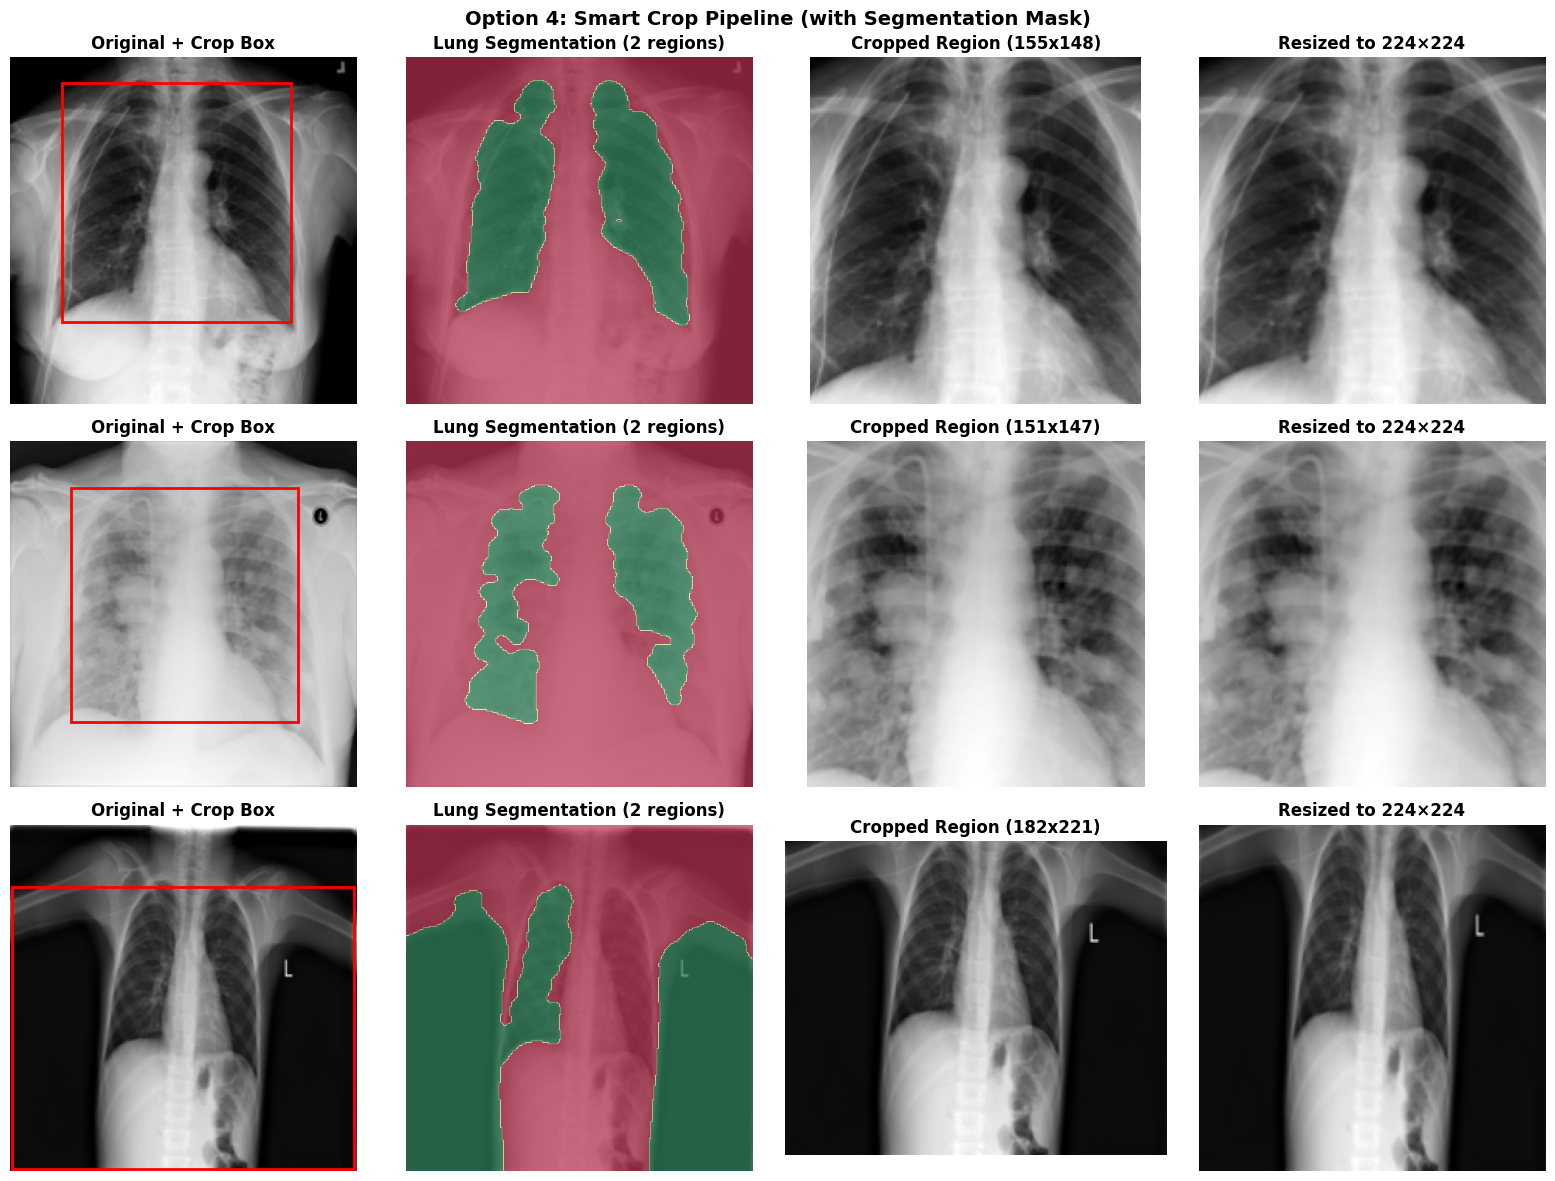

✅ Smart cropping visualization complete
   ✓ Crop padding applied: 1px
   ✓ Segmentation limited to 2 regions (left & right lungs)


In [8]:
# ============================================
# 👁️ Step 5: Visualize Smart Cropping with Segmentation Mask
# ============================================

# Randomly sample 3 indices from the dataset
sample_indices = list(np.random.choice(len(df), size=3, replace=False))
print(f"🎲 Randomly selected image indices: {sample_indices}")

fig, axes = plt.subplots(len(sample_indices), 4, figsize=(16, 4*len(sample_indices)))

for i, idx in enumerate(sample_indices):
    img_path = df.iloc[idx]['Image Path']
    img = Image.open(img_path).convert('L')
    img = img.resize((cfg.img_size, cfg.img_size), Image.LANCZOS)
    img_np = np.array(img, dtype=np.float32) / 255.0
    
    # Segment and crop
    img_name = df.iloc[sample_indices[i]]["Image Index"]
    lung_mask = load_precomputed_mask(img_name)
    # FIXED: Ensure only 2 regions are kept for segmentation
    
    img_cropped, mask_cropped = context_aware_crop(img_np, lung_mask, cfg.crop_padding, cfg.min_crop_ratio)
    
    # Resize back
    img_resized = cv2.resize(img_cropped, (cfg.img_size, cfg.img_size))
    
    # Plot 1: Original with bounding box
    axes[i, 0].imshow(img_np, cmap='gray')
    bbox = get_lung_bounding_box(lung_mask)
    if bbox:
        y_min, y_max, x_min, x_max = bbox
        # FIXED: Crop box visualization should match actual crop logic
        rect = plt.Rectangle((x_min+cfg.crop_padding, y_min+cfg.crop_padding),
                             x_max-x_min-2*cfg.crop_padding, y_max-y_min-2*cfg.crop_padding,
                             linewidth=2, edgecolor='r', facecolor='none')
        axes[i, 0].add_patch(rect)
    axes[i, 0].set_title('Original + Crop Box', fontweight='bold')
    axes[i, 0].axis('off')
    
    # Plot 2: Segmentation mask (with only 2 regions)
    axes[i, 1].imshow(lung_mask, cmap='RdYlGn', alpha=0.8)
    axes[i, 1].imshow(img_np, cmap='gray', alpha=0.3)
    num_regions = len(np.unique(cv2.connectedComponents(
        (lung_mask * 255).astype(np.uint8))[1])) - 1
    axes[i, 1].set_title(f'Lung Segmentation ({num_regions} regions)', fontweight='bold')
    axes[i, 1].axis('off')
    
    # Plot 3: Cropped region
    axes[i, 2].imshow(img_cropped, cmap='gray')
    axes[i, 2].set_title(f'Cropped Region ({img_cropped.shape[0]}x{img_cropped.shape[1]})', fontweight='bold')
    axes[i, 2].axis('off')
    
    # Plot 4: Resized to 224×224
    axes[i, 3].imshow(img_resized, cmap='gray')
    axes[i, 3].set_title('Resized to 224×224', fontweight='bold')
    axes[i, 3].axis('off')

plt.suptitle('Option 4: Smart Crop Pipeline (with Segmentation Mask)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('option4_smart_crop_with_segmentation.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Smart cropping visualization complete")
print(f"   ✓ Crop padding applied: {cfg.crop_padding}px")
print(f"   ✓ Segmentation limited to 2 regions (left & right lungs)")

In [9]:

# ============================================
# 🔄 Step 6: Context-Aware Augmentation
# ============================================

def apply_context_augmentation(image):
    """
    Apply augmentations that preserve anatomical context
    Suitable for already-cropped lung images
    """
    # Small rotation to preserve anatomy
    if random.random() > 0.5:
        angle = random.uniform(-10, 10)
        h, w = image.shape[:2]
        M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1.0)
        image = cv2.warpAffine(image, M, (w, h), borderMode=cv2.BORDER_REPLICATE)
    
    # Horizontal flip (chest X-rays can be left-right symmetric)
    # Note: .copy() is needed to avoid negative strides from np.fliplr
    if random.random() > 0.5:
        image = np.fliplr(image).copy()
    
    # Brightness adjustment
    if random.random() > 0.5:
        factor = random.uniform(0.8, 1.2)
        image = np.clip(image * factor, 0, 1)
    
    # Contrast adjustment
    if random.random() > 0.5:
        mean = image.mean()
        factor = random.uniform(0.8, 1.2)
        image = np.clip((image - mean) * factor + mean, 0, 1)
    
    # Gaussian noise
    if random.random() > 0.6:
        noise = np.random.normal(0, 0.02, image.shape)
        image = np.clip(image + noise, 0, 1)
    
    return image

print("✅ Context-aware augmentation function defined")

✅ Context-aware augmentation function defined


In [10]:
# ============================================
# 📦 Step 7: Dataset Classes
# ============================================

class SegmentationGuidedDataset(Dataset):
    """SSL pretrain dataset with segmentation-guided cropping."""
    def __init__(self, df, img_size=224, padding=20, min_crop_ratio=0.5, cache_masks=False):
        self.df = df.copy().reset_index(drop=True)
        self.img_size = img_size
        self.padding = padding
        self.min_crop_ratio = min_crop_ratio
        self.mask_cache = None
        
        if cache_masks:
            print("⚡ Pre-loading lung masks into RAM...")
            self.mask_cache = {}
            for img_name in tqdm(self.df["Image Index"], desc="Caching masks"):
                self.mask_cache[img_name] = load_precomputed_mask(img_name)
            print(f"  ✅ {len(self.mask_cache)} masks cached")
        
        print(f"📦 SegmentationGuidedDataset: {len(self.df)} samples (cache={cache_masks})")
    
    def __len__(self):
        return len(self.df)
    
    def _get_mask(self, img_name):
        if self.mask_cache is not None:
            return self.mask_cache[img_name]
        return load_precomputed_mask(img_name)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        img = cv2.imread(row["Image Path"], cv2.IMREAD_GRAYSCALE)
        if img is None:
            img = np.zeros((self.img_size, self.img_size), dtype=np.uint8)
        if img.shape[0] != self.img_size:
            img = cv2.resize(img, (self.img_size, self.img_size))
        img = img.astype(np.float32) / 255.0
        
        lung_mask = self._get_mask(row["Image Index"])
        img_cropped, _ = context_aware_crop(img, lung_mask, self.padding, self.min_crop_ratio)
        img_resized = cv2.resize(img_cropped, (self.img_size, self.img_size))
        
        view1 = apply_context_augmentation(img_resized.copy())
        view2 = apply_context_augmentation(img_resized.copy())
        
        view1 = torch.from_numpy(view1[None, ...]).float()
        view2 = torch.from_numpy(view2[None, ...]).float()
        return view1, view2


class ClassificationDataset(Dataset):
    """Classification dataset with segmentation-guided preprocessing."""
    def __init__(self, df, disease_categories, img_size=224, padding=20, is_training=False, cache_masks=False):
        self.df = df.copy().reset_index(drop=True)
        self.disease_categories = disease_categories
        self.img_size = img_size
        self.padding = padding
        self.is_training = is_training
        self.mask_cache = None
        
        if cache_masks:
            self.mask_cache = {}
            for img_name in self.df["Image Index"]:
                self.mask_cache[img_name] = load_precomputed_mask(img_name)
        
        print(f"📦 ClassificationDataset: {len(self.df)} samples (training={is_training}, cache={cache_masks})")
    
    def __len__(self):
        return len(self.df)
    
    def _get_mask(self, img_name):
        if self.mask_cache is not None:
            return self.mask_cache[img_name]
        return load_precomputed_mask(img_name)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        img = cv2.imread(row["Image Path"], cv2.IMREAD_GRAYSCALE)
        if img is None:
            img = np.zeros((self.img_size, self.img_size), dtype=np.uint8)
        if img.shape[0] != self.img_size:
            img = cv2.resize(img, (self.img_size, self.img_size))
        img = img.astype(np.float32) / 255.0
        
        lung_mask = self._get_mask(row["Image Index"])
        img_cropped, _ = context_aware_crop(img, lung_mask, self.padding)
        img_resized = cv2.resize(img_cropped, (self.img_size, self.img_size))
        
        if self.is_training:
            if np.random.random() > 0.5:
                img_resized = np.fliplr(img_resized).copy()
            img_resized = img_resized * (0.8 + 0.4 * np.random.random())
            mean = img_resized.mean()
            img_resized = (img_resized - mean) * (0.8 + 0.4 * np.random.random()) + mean
            if np.random.random() > 0.5:
                angle = np.random.uniform(-10, 10)
                h, w = img_resized.shape[:2]
                M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1.0)
                img_resized = cv2.warpAffine(img_resized, M, (w, h), borderMode=cv2.BORDER_REPLICATE)
            img_resized = np.clip(img_resized, 0, 1)
        
        img = torch.from_numpy(img_resized[None, ...].copy()).float()
        labels = torch.tensor([row[d] for d in self.disease_categories], dtype=torch.float32)
        return img, labels

print("✅ Dataset classes defined")


✅ Dataset classes defined


In [11]:
# ============================================
# 🏗️ Step 8: Model Architecture
# ============================================

def conv_block(in_c, out_c, kernel=3, stride=1, padding=1):
    return nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel, stride, padding),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True)
    )

def residual_block(channels):
    return nn.Sequential(
        conv_block(channels, channels),
        conv_block(channels, channels)
    )

class Encoder(nn.Module):
    def __init__(self, in_channels=1, feat_dim=256):
        super().__init__()
        self.features = nn.Sequential(
            conv_block(in_channels, 64), residual_block(64), nn.MaxPool2d(2),
            conv_block(64, 128), residual_block(128), nn.MaxPool2d(2),
            conv_block(128, 256), residual_block(256), residual_block(256), nn.MaxPool2d(2),
            conv_block(256, 512), residual_block(512), residual_block(512), nn.MaxPool2d(2),
            conv_block(512, 512), residual_block(512), nn.AdaptiveAvgPool2d((1, 1))
        )
        self.fc = nn.Sequential(
            nn.Linear(512, 512), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(512, feat_dim)
        )
    def forward(self, x):
        x = self.features(x)
        return self.fc(x.view(x.size(0), -1))

class ProjectionHead(nn.Module):
    def __init__(self, feat_dim=256, proj_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(feat_dim, feat_dim), nn.BatchNorm1d(feat_dim), nn.ReLU(),
            nn.Linear(feat_dim, proj_dim)
        )
    def forward(self, x):
        return self.net(x)

class Decoder(nn.Module):
    def __init__(self, feat_dim=256, img_size=224):
        super().__init__()
        self.init_size = img_size // 32
        self.fc = nn.Sequential(
            nn.Linear(feat_dim, 256 * self.init_size * self.init_size), nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 4, 2, 1), nn.BatchNorm2d(16), nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 4, 2, 1), nn.Sigmoid()
        )
    def forward(self, z):
        x = self.fc(z)
        return self.decoder(x.view(z.size(0), 256, self.init_size, self.init_size))

class Classifier(nn.Module):
    def __init__(self, feat_dim=256, num_classes=14):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(feat_dim, 256), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        return self.net(x)

encoder = Encoder(feat_dim=cfg.feat_dim).to(cfg.device)
proj_head = ProjectionHead(cfg.feat_dim, cfg.proj_dim).to(cfg.device)
decoder = Decoder(cfg.feat_dim, cfg.img_size).to(cfg.device)

total_params = sum(p.numel() for m in [encoder, proj_head, decoder] for p in m.parameters())
print(f"✅ Models initialized ({total_params:,} parameters)")

✅ Models initialized (25,224,017 parameters)


In [12]:
# ============================================
# 🔥 Step 9: Loss Functions
# ============================================

def nt_xent_loss(z1, z2, temperature=0.1):
    device = z1.device
    z1 = F.normalize(z1, dim=1)
    z2 = F.normalize(z2, dim=1)
    batch_size = z1.shape[0]
    representations = torch.cat([z1, z2], dim=0)
    similarity = torch.matmul(representations, representations.T) / temperature
    mask = torch.eye(2 * batch_size, dtype=torch.bool, device=device)
    similarity = similarity.masked_fill(mask, -float('inf'))
    labels = torch.cat([torch.arange(batch_size) + batch_size,
                        torch.arange(batch_size)]).to(device)
    return F.cross_entropy(similarity, labels)


class FocalLoss(nn.Module):
    """
    ⭐ Focal Loss for handling class imbalance (from DannyNet SOTA)
    FL(p_t) = -alpha * (1 - p_t)^gamma * log(p_t)
    """
    def __init__(self, alpha=1.0, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
    
    def forward(self, inputs, targets):
        bce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * bce_loss
        return focal_loss.mean()

print("✅ Loss functions defined")
print("   ⭐ FocalLoss: For class imbalance (α=1.0, γ=2.0)")

✅ Loss functions defined
   ⭐ FocalLoss: For class imbalance (α=1.0, γ=2.0)


In [13]:
# ============================================
# 📊 Step 10: Create Data Loaders (Patient-Level Split)
# ============================================

# 🐳 Docker: check shared memory size (PyTorch workers need enough /dev/shm)
import shutil
_shm = shutil.disk_usage("/dev/shm").total if os.path.exists("/dev/shm") else float("inf")
if _shm < 1e9 and cfg.num_workers > 0:
    print(f"⚠️ Docker /dev/shm = {_shm/1e6:.0f}MB (too small for {cfg.num_workers} workers)")
    print("   👉 Fix: docker run --shm-size=8g ... OR setting num_workers=0")
    print("   Fix: docker run --shm-size=8g ...")
print(f"⚙️ DataLoader config: num_workers={cfg.num_workers}, cache_masks={cfg.cache_masks}")

print("🔀 PATIENT-LEVEL SPLITTING")
print("="*60)

unique_patients = df['Patient ID'].unique()
print(f"Total unique patients: {len(unique_patients):,}")

# Split patients: 93% train, 5% val, 2% test
train_val_patients, test_patients = train_test_split(
    unique_patients, test_size=0.02, random_state=42
)
train_patients, val_patients = train_test_split(
    train_val_patients, test_size=0.052, random_state=42
)

train_df = df[df['Patient ID'].isin(train_patients)].copy()
val_df = df[df['Patient ID'].isin(val_patients)].copy()
test_df = df[df['Patient ID'].isin(test_patients)].copy()

print(f"✓ Train: {len(train_df):,} images from {len(train_patients):,} patients")
print(f"✓ Val: {len(val_df):,} images from {len(val_patients):,} patients")
print(f"✓ Test: {len(test_df):,} images from {len(test_patients):,} patients")
print("="*60)

if cfg.use_subset:
    train_df = train_df.head(cfg.subset_size)
    val_df = val_df.head(cfg.subset_size // 4)
    test_df = test_df.head(cfg.subset_size // 8)
    print(f"⚡ Using subset: {len(train_df)} train, {len(val_df)} val, {len(test_df)} test")

# Datasets - NOW WITH AUGMENTATION FOR TRAINING
train_pretrain_ds = SegmentationGuidedDataset(
    train_df, img_size=cfg.img_size, padding=cfg.crop_padding,
    min_crop_ratio=cfg.min_crop_ratio, cache_masks=cfg.cache_masks)
train_class_ds = ClassificationDataset(
    train_df, DISEASE_CATEGORIES, cfg.img_size, cfg.crop_padding,
    is_training=True, cache_masks=cfg.cache_masks)
val_class_ds = ClassificationDataset(val_df, DISEASE_CATEGORIES, cfg.img_size, cfg.crop_padding, is_training=False, cache_masks=cfg.cache_masks)
test_class_ds = ClassificationDataset(test_df, DISEASE_CATEGORIES, cfg.img_size, cfg.crop_padding, is_training=False, cache_masks=cfg.cache_masks)

# DataLoaders - FAST PIPELINE (like tf.data)
# 🚀 num_workers: Parallel data loading (like num_parallel_calls)
# 🚀 pin_memory: Faster CPU→GPU transfer  
# 🚀 prefetch_factor: Prefetch batches per worker (like prefetch)
# 🚀 persistent_workers: Keep workers alive between epochs
# ⚡ When masks are cached in RAM, use num_workers=0 to avoid memory duplication
_nw = cfg.num_workers
_persist = _nw > 0
_prefetch = 2 if _nw > 0 else None

pretrain_loader = DataLoader(
    train_pretrain_ds, batch_size=cfg.batch_size, shuffle=True,
    num_workers=_nw, pin_memory=True, drop_last=True,
    prefetch_factor=_prefetch, persistent_workers=_persist
)
train_loader = DataLoader(
    train_class_ds, batch_size=cfg.batch_size, shuffle=True,
    num_workers=_nw, pin_memory=True, drop_last=True,
    prefetch_factor=_prefetch, persistent_workers=_persist
)
val_loader = DataLoader(
    val_class_ds, batch_size=cfg.batch_size, shuffle=False,
    num_workers=_nw, pin_memory=True,
    prefetch_factor=_prefetch, persistent_workers=_persist
)
test_loader = DataLoader(
    test_class_ds, batch_size=cfg.batch_size, shuffle=False,
    num_workers=_nw, pin_memory=True,
    prefetch_factor=_prefetch, persistent_workers=_persist
)

print(f"✅ DataLoaders ready - FAST PIPELINE (with training augmentation)")
print(f"   Train batches: {len(pretrain_loader)}")
print(f"   Test batches: {len(test_loader)}")

⚙️ DataLoader config: num_workers=8, cache_masks=True
🔀 PATIENT-LEVEL SPLITTING
Total unique patients: 30,805
✓ Train: 103,847 images from 28,618 patients
✓ Val: 5,974 images from 1,570 patients
✓ Test: 2,299 images from 617 patients
⚡ Pre-loading lung masks into RAM...


Caching masks: 100%|██████████| 103847/103847 [00:29<00:00, 3535.70it/s]


  ✅ 103847 masks cached
📦 SegmentationGuidedDataset: 103847 samples (cache=True)
📦 ClassificationDataset: 103847 samples (training=True, cache=True)
📦 ClassificationDataset: 5974 samples (training=False, cache=True)
📦 ClassificationDataset: 2299 samples (training=False, cache=True)
✅ DataLoaders ready - FAST PIPELINE (with training augmentation)
   Train batches: 1622
   Test batches: 36


In [ ]:
# ============================================
# 🚀 Step 11: SSL Pretraining
# ============================================

# Clear GPU cache before training
if torch.cuda.is_available():
    torch.cuda.empty_cache()

optimizer_ssl = torch.optim.Adam(
    list(encoder.parameters()) + list(proj_head.parameters()) + list(decoder.parameters()),
    lr=cfg.lr_pretrain, weight_decay=1e-4
)

ssl_history = {'loss': [], 'contrastive': [], 'reconstruction': []}
START_EPOCH = 1

if RESUME_SSL_PRETRAINING:
    ckpt_file = find_latest_checkpoint(f'{OPTION_NAME}_ssl') if SSL_CHECKPOINT_FILE == "latest" else SSL_CHECKPOINT_FILE
    if ckpt_file:
        checkpoint = load_checkpoint(ckpt_file)
        if checkpoint:
            encoder.load_state_dict(checkpoint['encoder'])
            proj_head.load_state_dict(checkpoint['proj_head'])
            decoder.load_state_dict(checkpoint['decoder'])
            if 'optimizer' in checkpoint: optimizer_ssl.load_state_dict(checkpoint['optimizer'])
            ssl_history = checkpoint.get('ssl_history', ssl_history)
            START_EPOCH = checkpoint['epoch'] + 1
            print(f"🔄 Resuming from epoch {START_EPOCH}")
    else:
        print("⚠️ No checkpoint found. Starting fresh.")

if START_EPOCH > cfg.pretrain_epochs:
    print(f"✅ SSL Pretraining already complete")
else:
    print(f"\n🚀 Starting Option 3: Mask-Guided SSL!")
    print(f"   Epochs: {START_EPOCH} → {cfg.pretrain_epochs}")
    print("=" * 60)
    SAVE_EVERY = 5
    
    for epoch in range(START_EPOCH, cfg.pretrain_epochs + 1):
        encoder.train()
        proj_head.train()
        decoder.train()
        
        total_loss = total_cont = total_recon = 0
        
        loader = tqdm(pretrain_loader, desc=f"Epoch {epoch}/{cfg.pretrain_epochs}") if not IN_KAGGLE else pretrain_loader
        for view1, view2 in loader:
            view1 = view1.to(cfg.device)
            view2 = view2.to(cfg.device)
            
            optimizer_ssl.zero_grad()
            
            z1, z2 = encoder(view1), encoder(view2)
            p1, p2 = proj_head(z1), proj_head(z2)
            cont_loss = nt_xent_loss(p1, p2, cfg.temperature)
            
            rec1, rec2 = decoder(z1), decoder(z2)
            recon_loss = (F.mse_loss(rec1, view1) + F.mse_loss(rec2, view2)) / 2
            
            loss = cont_loss + 0.5 * recon_loss
            loss.backward()
            optimizer_ssl.step()
            
            total_loss += loss.item()
            total_cont += cont_loss.item()
            total_recon += recon_loss.item()
            if not IN_KAGGLE:
                loader.set_postfix({'loss': f'{loss.item():.4f}'})
            
            # Free memory
            del z1, z2, p1, p2, rec1, rec2, loss, cont_loss, recon_loss
        
        # Clear cache at end of epoch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        
        n = len(pretrain_loader)
        ssl_history['loss'].append(total_loss / n)
        ssl_history['contrastive'].append(total_cont / n)
        ssl_history['reconstruction'].append(total_recon / n)
        
        print(f"Epoch {epoch}: Loss={total_loss/n:.4f}, Cont={total_cont/n:.4f}, Recon={total_recon/n:.4f}")
        
    if epoch % SAVE_EVERY == 0 or epoch == cfg.pretrain_epochs:
        save_checkpoint({
            'epoch': epoch, 'encoder': encoder.state_dict(),
            'proj_head': proj_head.state_dict(), 'decoder': decoder.state_dict(),
            'optimizer': optimizer_ssl.state_dict(), 'ssl_history': ssl_history,
        }, f'{OPTION_NAME}_ssl_latest.pth')
    if epoch % SAVE_EVERY == 0 or epoch == cfg.pretrain_epochs:
        save_checkpoint({
            'epoch': epoch, 'encoder': encoder.state_dict(),
            'proj_head': proj_head.state_dict(), 'decoder': decoder.state_dict(),
            'ssl_history': ssl_history,
        }, f'{OPTION_NAME}_ssl_epoch{epoch}.pth')
    
    print("\n✅ Mask-Guided SSL!")

⚠️ No checkpoint found. Starting fresh.

🚀 Starting Option 3: Mask-Guided SSL!
   Epochs: 1 → 25


Epoch 1/25: 100%|██████████| 1622/1622 [11:25<00:00,  2.37it/s, loss=0.4010]


Epoch 1: Loss=0.9232, Cont=0.9093, Recon=0.0279


Epoch 2/25: 100%|██████████| 1622/1622 [11:17<00:00,  2.39it/s, loss=0.2204]


Epoch 2: Loss=0.3406, Cont=0.3266, Recon=0.0279


Epoch 3/25: 100%|██████████| 1622/1622 [11:17<00:00,  2.39it/s, loss=0.3167]


Epoch 3: Loss=0.2467, Cont=0.2327, Recon=0.0280


Epoch 4/25: 100%|██████████| 1622/1622 [11:17<00:00,  2.40it/s, loss=0.1666]


Epoch 4: Loss=0.1998, Cont=0.1861, Recon=0.0275


Epoch 5/25: 100%|██████████| 1622/1622 [11:16<00:00,  2.40it/s, loss=0.1483]


Epoch 5: Loss=0.1782, Cont=0.1642, Recon=0.0280


Epoch 6/25: 100%|██████████| 1622/1622 [11:15<00:00,  2.40it/s, loss=0.1624]


Epoch 6: Loss=0.1541, Cont=0.1401, Recon=0.0279


Epoch 7/25: 100%|██████████| 1622/1622 [11:14<00:00,  2.41it/s, loss=0.1043]


Epoch 7: Loss=0.1246, Cont=0.1107, Recon=0.0278


Epoch 8/25: 100%|██████████| 1622/1622 [11:12<00:00,  2.41it/s, loss=0.1286]


Epoch 8: Loss=0.1075, Cont=0.0937, Recon=0.0274


Epoch 9/25: 100%|██████████| 1622/1622 [11:12<00:00,  2.41it/s, loss=0.0695]


Epoch 9: Loss=0.0967, Cont=0.0830, Recon=0.0274


Epoch 10/25: 100%|██████████| 1622/1622 [11:12<00:00,  2.41it/s, loss=0.0607]


Epoch 10: Loss=0.0871, Cont=0.0736, Recon=0.0271


Epoch 11/25: 100%|██████████| 1622/1622 [11:13<00:00,  2.41it/s, loss=0.0738]


Epoch 11: Loss=0.0799, Cont=0.0665, Recon=0.0268


Epoch 12/25: 100%|██████████| 1622/1622 [11:12<00:00,  2.41it/s, loss=0.1039]


Epoch 12: Loss=0.0794, Cont=0.0660, Recon=0.0269


Epoch 13/25: 100%|██████████| 1622/1622 [11:12<00:00,  2.41it/s, loss=0.0509]


Epoch 13: Loss=0.0747, Cont=0.0614, Recon=0.0266


Epoch 14/25: 100%|██████████| 1622/1622 [11:12<00:00,  2.41it/s, loss=0.0810]


Epoch 14: Loss=0.0703, Cont=0.0571, Recon=0.0265


Epoch 15/25: 100%|██████████| 1622/1622 [11:13<00:00,  2.41it/s, loss=0.0506]


Epoch 15: Loss=0.0699, Cont=0.0567, Recon=0.0264


Epoch 16/25:   0%|          | 0/1622 [00:00<?, ?it/s]

In [ ]:
# ============================================
# 📈 Step 12: Plot SSL Curves & Save Model
# ============================================

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(ssl_history['loss'], 'b-', linewidth=2)
axes[0].set_title('Total Loss')
axes[0].set_xlabel('Epoch')
axes[0].grid(True, alpha=0.3)

axes[1].plot(ssl_history['contrastive'], 'r-', linewidth=2)
axes[1].set_title('Contrastive Loss')
axes[1].set_xlabel('Epoch')
axes[1].grid(True, alpha=0.3)

axes[2].plot(ssl_history['reconstruction'], 'g-', linewidth=2)
axes[2].set_title('Reconstruction Loss')
axes[2].set_xlabel('Epoch')
axes[2].grid(True, alpha=0.3)

plt.suptitle('Option 4: Segmentation-Guided SSL Training', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('option4_ssl_curves.png', dpi=150, bbox_inches='tight')
plt.show()

torch.save({
    'encoder': encoder.state_dict(),
    'proj_head': proj_head.state_dict(),
    'decoder': decoder.state_dict(),
}, 'option4_ssl_pretrained.pth')

print("💾 Pretrained model saved: option4_ssl_pretrained.pth")

In [ ]:
# ============================================
# 🎯 Step 13-15: Fine-tuning
# ============================================
# KEY IMPROVEMENTS (inspired by DannyNet SOTA):
# 1. UNFREEZE encoder with differential learning rate
# 2. Use Focal Loss instead of BCE
# 3. Use AdamW optimizer
# 4. More aggressive LR scheduler (factor=0.1, patience=2)
# ============================================

# ✅ UNFREEZE encoder for fine-tuning (CRITICAL for performance!)
for param in encoder.parameters():
    param.requires_grad = True  # UNFROZEN!
encoder.train()

classifier = Classifier(cfg.feat_dim, len(DISEASE_CATEGORIES)).to(cfg.device)

# ✅ Use Focal Loss
criterion = FocalLoss(alpha=1.0, gamma=2.0)

# ✅ Differential learning rates with AdamW
encoder_lr = cfg.lr_finetune / 10
classifier_lr = cfg.lr_finetune

optimizer_ft = torch.optim.AdamW([
    {'params': encoder.parameters(), 'lr': encoder_lr},
    {'params': classifier.parameters(), 'lr': classifier_lr}
], weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_ft, mode='max', patience=2, factor=0.1, min_lr=1e-7
)

print("🔧 Fine-tuning Configuration:")
print(f"   ✅ Encoder: UNFROZEN with LR={encoder_lr:.2e}")
print(f"   ✅ Classifier LR: {classifier_lr:.2e}")
print(f"   ✅ Loss: FocalLoss (α=1.0, γ=2.0)")
print(f"   ✅ Optimizer: AdamW")

finetune_history = {'train_loss': [], 'train_auc': [], 'val_loss': [], 'val_auc': []}
best_val_auc = 0
FINETUNE_START_EPOCH = 1

if RESUME_FINETUNING:
    ckpt_file = find_latest_checkpoint(f'{OPTION_NAME}_finetune') if FINETUNE_CHECKPOINT_FILE == "latest" else FINETUNE_CHECKPOINT_FILE
    if ckpt_file:
        ft_ckpt = load_checkpoint(ckpt_file)
        if ft_ckpt:
            classifier.load_state_dict(ft_ckpt['classifier'])
            if 'encoder' in ft_ckpt:
                encoder.load_state_dict(ft_ckpt['encoder'])
            if 'optimizer' in ft_ckpt:
                try:
                    optimizer_ft.load_state_dict(ft_ckpt['optimizer'])
                except:
                    print("⚠️ Optimizer state incompatible, starting fresh")
            finetune_history = ft_ckpt.get('finetune_history', finetune_history)
            best_val_auc = ft_ckpt.get('best_val_auc', 0)
            FINETUNE_START_EPOCH = ft_ckpt['epoch'] + 1
            print(f"🔄 Resuming fine-tuning from epoch {FINETUNE_START_EPOCH}")

if FINETUNE_START_EPOCH > cfg.finetune_epochs:
    print(f"✅ Fine-tuning already complete")
else:
    print(f"\n🎯 Starting Fine-tuning (ENCODER UNFROZEN)")
    print(f"   Epochs: {FINETUNE_START_EPOCH} → {cfg.finetune_epochs}")
    print("=" * 50)
    
    for epoch in range(FINETUNE_START_EPOCH, cfg.finetune_epochs + 1):
        encoder.train()  # Encoder is also training now!
        classifier.train()
        train_loss = 0
        train_preds, train_targets = [], []
        
        loader = tqdm(train_loader, desc=f"Train {epoch}/{cfg.finetune_epochs}") if not IN_KAGGLE else train_loader
        for images, targets in loader:
            images, targets = images.to(cfg.device), targets.to(cfg.device)
            optimizer_ft.zero_grad()
            
            # ✅ NO torch.no_grad() - encoder is being fine-tuned!
            features = encoder(images)
            logits = classifier(features)
            loss = criterion(logits, targets)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(encoder.parameters(), max_norm=1.0)
            torch.nn.utils.clip_grad_norm_(classifier.parameters(), max_norm=1.0)
            optimizer_ft.step()
            
            train_loss += loss.item()
            train_preds.append(torch.sigmoid(logits).detach().cpu())
            train_targets.append(targets.cpu())
        
        encoder.eval()
        classifier.eval()
        val_loss = 0
        val_preds, val_targets = [], []
        
        with torch.no_grad():
            for images, targets in val_loader:
                images, targets = images.to(cfg.device), targets.to(cfg.device)
                features = encoder(images)
                logits = classifier(features)
                val_loss += criterion(logits, targets).item()
                val_preds.append(torch.sigmoid(logits).cpu())
                val_targets.append(targets.cpu())
        
        train_preds, train_targets = torch.cat(train_preds).numpy(), torch.cat(train_targets).numpy()
        val_preds, val_targets = torch.cat(val_preds).numpy(), torch.cat(val_targets).numpy()
        
        train_auc = np.mean([roc_auc_score(train_targets[:, i], train_preds[:, i]) 
                             for i in range(len(DISEASE_CATEGORIES)) if len(np.unique(train_targets[:, i])) > 1])
        val_auc = np.mean([roc_auc_score(val_targets[:, i], val_preds[:, i]) 
                           for i in range(len(DISEASE_CATEGORIES)) if len(np.unique(val_targets[:, i])) > 1])
        
        finetune_history['train_loss'].append(train_loss / len(train_loader))
        finetune_history['train_auc'].append(train_auc)
        finetune_history['val_loss'].append(val_loss / len(val_loader))
        finetune_history['val_auc'].append(val_auc)
        scheduler.step(val_auc)
        
        current_lr = optimizer_ft.param_groups[0]['lr']
        print(f"Epoch {epoch}: Train AUC={train_auc:.4f}, Val AUC={val_auc:.4f}, LR={current_lr:.2e}")
        
        if val_auc > best_val_auc:
            best_val_auc = val_auc
            save_checkpoint({'encoder': encoder.state_dict(), 'classifier': classifier.state_dict(),
                            'val_auc': val_auc, 'epoch': epoch}, f'{OPTION_NAME}_best_model.pth')
            print(f"  ✅ Best model saved! Val AUC: {val_auc:.4f}")
        
        if epoch % 5 == 0 or epoch == cfg.finetune_epochs:
            save_checkpoint({'epoch': epoch, 'encoder': encoder.state_dict(),
                            'classifier': classifier.state_dict(),
                            'optimizer': optimizer_ft.state_dict(), 'finetune_history': finetune_history,
                            'best_val_auc': best_val_auc}, f'{OPTION_NAME}_finetune_latest.pth')
    
    print(f"\n🏆 Best Validation AUC: {best_val_auc:.4f}")

In [ ]:
# ============================================
# 📊 Step 16: Final Evaluation & Test Set
# ============================================

from sklearn.metrics import f1_score, precision_score, recall_score

best_model_path = os.path.join(CHECKPOINT_DIR, f'{OPTION_NAME}_best_model.pth')
checkpoint = torch.load(best_model_path)
encoder.load_state_dict(checkpoint['encoder'])
classifier.load_state_dict(checkpoint['classifier'])
encoder.eval()
classifier.eval()

# Validation Set
all_preds, all_targets = [], []
with torch.no_grad():
    loader = tqdm(val_loader, desc="Evaluating Val") if not IN_KAGGLE else val_loader
    for images, targets in loader:
        images = images.to(cfg.device)
        features = encoder(images)
        logits = classifier(features)
        all_preds.append(torch.sigmoid(logits).cpu())
        all_targets.append(targets)

all_preds = torch.cat(all_preds).numpy()
all_targets = torch.cat(all_targets).numpy()

print("\n📊 Validation Set - Per-Disease AUC Scores:")
print("=" * 40)
val_auc_scores = []
for i, disease in enumerate(DISEASE_CATEGORIES):
    if len(np.unique(all_targets[:, i])) > 1:
        auc = roc_auc_score(all_targets[:, i], all_preds[:, i])
        val_auc_scores.append((disease, auc))
        print(f"{disease:20s}: {auc:.4f}")

val_mean_auc = np.mean([a for _, a in val_auc_scores])
print(f"\n{'Val Mean AUC':20s}: {val_mean_auc:.4f}")

# ============================================
# 🎯 Find Optimal Per-Disease Thresholds
# ============================================
print("\n" + "="*60)
print("🎯 OPTIMAL THRESHOLD SEARCH (per-disease)")
print("="*60)

optimal_thresholds = {}
for i, disease in enumerate(DISEASE_CATEGORIES):
    if len(np.unique(all_targets[:, i])) > 1:
        best_f1, best_thresh = 0, 0.5
        for thresh in np.arange(0.1, 0.9, 0.02):
            preds_binary = (all_preds[:, i] > thresh).astype(int)
            if preds_binary.sum() > 0 and (1 - preds_binary).sum() > 0:
                f1 = f1_score(all_targets[:, i], preds_binary, zero_division=0)
                if f1 > best_f1:
                    best_f1, best_thresh = f1, thresh
        optimal_thresholds[disease] = best_thresh
        print(f"{disease:20s}: optimal thresh = {best_thresh:.2f}, F1 = {best_f1:.4f}")

# ============================================
# 🧪 Test Set Evaluation (Held-Out)
# ============================================

print("\n" + "="*60)
print("🧪 TEST SET EVALUATION (Patient-Level Held-Out)")
print("="*60)

test_preds, test_targets = [], []
with torch.no_grad():
    loader = tqdm(test_loader, desc="Evaluating Test") if not IN_KAGGLE else test_loader
    for images, targets in loader:
        images = images.to(cfg.device)
        features = encoder(images)
        logits = classifier(features)
        test_preds.append(torch.sigmoid(logits).cpu())
        test_targets.append(targets)

test_preds = torch.cat(test_preds).numpy()
test_targets = torch.cat(test_targets).numpy()

print("\n📊 Test Set - Per-Disease AUC Scores:")
print("=" * 40)
test_auc_scores = []
for i, disease in enumerate(DISEASE_CATEGORIES):
    if len(np.unique(test_targets[:, i])) > 1:
        auc = roc_auc_score(test_targets[:, i], test_preds[:, i])
        test_auc_scores.append((disease, auc))
        print(f"{disease:20s}: {auc:.4f}")

test_mean_auc = np.mean([a for _, a in test_auc_scores])
print(f"\n{'Test Mean AUC':20s}: {test_mean_auc:.4f}")

# Test with OPTIMAL thresholds
print("\n📊 Test Set - With Optimal Thresholds:")
print("=" * 60)
print(f"{'Disease':20s} {'AUC':>8s} {'Thresh':>8s} {'F1':>8s} {'Precision':>10s} {'Recall':>8s}")
print("-" * 60)

test_f1_scores = []
for i, disease in enumerate(DISEASE_CATEGORIES):
    if len(np.unique(test_targets[:, i])) > 1:
        auc = roc_auc_score(test_targets[:, i], test_preds[:, i])
        thresh = optimal_thresholds.get(disease, 0.5)
        preds_binary = (test_preds[:, i] > thresh).astype(int)
        f1 = f1_score(test_targets[:, i], preds_binary, zero_division=0)
        prec = precision_score(test_targets[:, i], preds_binary, zero_division=0)
        rec = recall_score(test_targets[:, i], preds_binary, zero_division=0)
        test_f1_scores.append(f1)
        print(f"{disease:20s} {auc:8.4f} {thresh:8.2f} {f1:8.4f} {prec:10.4f} {rec:8.4f}")

print("-" * 60)
print(f"{'MEAN':20s} {test_mean_auc:8.4f} {'--':>8s} {np.mean(test_f1_scores):8.4f}")

# Plot
test_auc_scores.sort(key=lambda x: x[1], reverse=True)
diseases, aucs = zip(*test_auc_scores)

plt.figure(figsize=(12, 6))
colors = ['green' if a >= 0.7 else 'orange' if a >= 0.6 else 'red' for a in aucs]
plt.barh(diseases, aucs, color=colors, alpha=0.8)
plt.axvline(0.5, color='red', linestyle='--', alpha=0.5, label='Random')
plt.axvline(test_mean_auc, color='blue', linestyle='--', alpha=0.7, label=f'Test Mean: {test_mean_auc:.3f}')
plt.xlabel('AUC Score')
plt.title('Option 4: Test Set Per-Disease AUC Performance (RECOMMENDED)', fontsize=14, fontweight='bold')
plt.legend()
plt.tight_layout()
plt.savefig('option4_test_auc_performance.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "=" * 70)
print("⭐ OPTION 4: SEGMENTATION-GUIDED SSL (RECOMMENDED) SUMMARY")
print("=" * 70)
print(f"Method: Context-Aware Crop + Context-Preserving Augmentation")
print(f"\nKey Advantages:")
print(f"  ✅ Eliminates non-anatomical background noise")
print(f"  ✅ Focuses SSL on lung tissue patterns")
print(f"  ✅ Maintains anatomical context during augmentation")
print(f"\nDataset: NIH Chest X-ray 14 (Patient-Level Split)")
print(f"  - Training: {len(train_df):,} images ({len(train_patients):,} patients)")
print(f"  - Validation: {len(val_df):,} images ({len(val_patients):,} patients)")
print(f"  - Test: {len(test_df):,} images ({len(test_patients):,} patients)")
print(f"\nResults:")
print(f"  📈 Validation Mean AUC: {val_mean_auc:.4f}")
print(f"  🧪 Test Mean AUC: {test_mean_auc:.4f}")
print("=" * 70)

In [ ]:
# ============================================
# 🎨 Step 17: Confusion Matrices Visualization (Option 4)
# ============================================

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Use optimal thresholds to create binary predictions
test_preds_binary = np.zeros_like(test_preds)
for i, disease in enumerate(DISEASE_CATEGORIES):
    thresh = optimal_thresholds.get(disease, 0.5)
    test_preds_binary[:, i] = (test_preds[:, i] > thresh).astype(int)

# ============================================
# 📊 Individual Confusion Matrices Per Disease
# ============================================

# Create a grid of confusion matrices (2 columns, 7 rows for 14 diseases)
n_diseases = len(DISEASE_CATEGORIES)
n_cols = 2
n_rows = (n_diseases + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 5*n_rows))
axes = axes.flatten()  # Flatten to 1D for easier indexing

for i, disease in enumerate(DISEASE_CATEGORIES):
    if len(np.unique(test_targets[:, i])) > 1:
        # Calculate confusion matrix
        cm = confusion_matrix(test_targets[:, i], test_preds_binary[:, i])
        
        # Plot
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i], 
                   cbar=False, annot_kws={'size': 12}, square=True)
        
        # Calculate accuracy for this disease
        accuracy = (cm[0, 0] + cm[1, 1]) / cm.sum()
        
        axes[i].set_title(f'{disease}\nAccuracy: {accuracy:.4f}', fontweight='bold', fontsize=11)
        axes[i].set_ylabel('True Label', fontsize=10)
        axes[i].set_xlabel('Predicted Label', fontsize=10)
        axes[i].set_xticklabels(['Negative', 'Positive'])
        axes[i].set_yticklabels(['Negative', 'Positive'], rotation=0)
    else:
        axes[i].text(0.5, 0.5, f'{disease}\n(Insufficient data)', 
                    ha='center', va='center', transform=axes[i].transAxes)
        axes[i].set_xticks([])
        axes[i].set_yticks([])

# Hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.suptitle('Confusion Matrices - Test Set Per Disease (with Optimal Thresholds)\nOption 4: Segmentation-Guided Crop', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(f'{OPTION_NAME}_confusion_matrices_per_disease.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Per-disease confusion matrices saved!")

# ============================================
# 📈 Macro Confusion Matrix (Aggregated)
# ============================================

# Aggregate across all diseases
cm_macro = confusion_matrix(test_targets.flatten(), test_preds_binary.flatten())

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm_macro, annot=True, fmt='d', cmap='RdYlGn', ax=ax, 
           cbar_kws={'label': 'Count'}, annot_kws={'size': 14}, square=True)

ax.set_title('Aggregated Confusion Matrix - All Diseases Combined\n(Test Set - Option 4)', 
            fontsize=13, fontweight='bold', pad=20)
ax.set_ylabel('True Label', fontsize=11)
ax.set_xlabel('Predicted Label', fontsize=11)
ax.set_xticklabels(['Negative', 'Positive'])
ax.set_yticklabels(['Negative', 'Positive'], rotation=0)

# Add metrics annotations
tn, fp, fn, tp = cm_macro.ravel()
accuracy = (tp + tn) / (tp + tn + fp + fn)
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
precision = tp / (tp + fp) if (tp + fp) > 0 else 0

metrics_text = f'Accuracy: {accuracy:.4f}\nSensitivity: {sensitivity:.4f}\nSpecificity: {specificity:.4f}\nPrecision: {precision:.4f}'
ax.text(0.98, 0.02, metrics_text, transform=ax.transAxes, fontsize=10,
       verticalalignment='bottom', horizontalalignment='right',
       bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.savefig(f'{OPTION_NAME}_confusion_matrix_macro.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✅ Macro confusion matrix saved!")
print(f"\nAggregated Metrics (All Diseases Combined):")
print(f"  Accuracy:    {accuracy:.4f}")
print(f"  Sensitivity: {sensitivity:.4f}")
print(f"  Specificity: {specificity:.4f}")
print(f"  Precision:   {precision:.4f}")

# ============================================
# 📋 Detailed Confusion Matrix Table
# ============================================

print("\n" + "="*80)
print("📋 PER-DISEASE CONFUSION MATRIX SUMMARY (Option 4)")
print("="*80)
print(f"{'Disease':20s} {'TN':>8s} {'FP':>8s} {'FN':>8s} {'TP':>8s} {'Accuracy':>10s} {'Sensitivity':>12s} {'Specificity':>12s}")
print("-"*80)

for i, disease in enumerate(DISEASE_CATEGORIES):
    if len(np.unique(test_targets[:, i])) > 1:
        cm = confusion_matrix(test_targets[:, i], test_preds_binary[:, i])
        tn, fp, fn, tp = cm.ravel()
        
        acc = (tp + tn) / (tp + tn + fp + fn)
        sens = tp / (tp + fn) if (tp + fn) > 0 else 0
        spec = tn / (tn + fp) if (tn + fp) > 0 else 0
        
        print(f"{disease:20s} {tn:8d} {fp:8d} {fn:8d} {tp:8d} {acc:10.4f} {sens:12.4f} {spec:12.4f}")

print("="*80)

In [ ]:
# ============================================
# 📈 Step 18: ROC Curves Visualization (Option 4)
# ============================================

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# ============================================
# 📊 Individual ROC Curves Per Disease (3x5 grid)
# ============================================

n_diseases = len(DISEASE_CATEGORIES)
n_cols = 5
n_rows = (n_diseases + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4*n_rows))
axes = axes.flatten()

for i, disease in enumerate(DISEASE_CATEGORIES):
    if len(np.unique(test_targets[:, i])) > 1:
        # Calculate ROC curve
        fpr, tpr, thresholds = roc_curve(test_targets[:, i], test_preds[:, i])
        roc_auc = auc(fpr, tpr)
        
        # Plot
        axes[i].plot(fpr, tpr, color='darkorange', lw=2.5, 
                    label=f'ROC (AUC = {roc_auc:.4f})')
        axes[i].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
        axes[i].fill_between(fpr, tpr, alpha=0.2, color='darkorange')
        
        axes[i].set_xlim([0.0, 1.0])
        axes[i].set_ylim([0.0, 1.05])
        axes[i].set_xlabel('False Positive Rate', fontsize=9)
        axes[i].set_ylabel('True Positive Rate', fontsize=9)
        axes[i].set_title(f'{disease}\nAUC = {roc_auc:.4f}', fontweight='bold', fontsize=10)
        axes[i].legend(loc="lower right", fontsize=8)
        axes[i].grid(True, alpha=0.3)
    else:
        axes[i].text(0.5, 0.5, f'{disease}\n(Insufficient data)', 
                    ha='center', va='center', transform=axes[i].transAxes, fontsize=10)
        axes[i].set_xticks([])
        axes[i].set_yticks([])

# Hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.suptitle('ROC Curves - Test Set Per Disease (Option 4: Segmentation-Guided Crop)', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(f'{OPTION_NAME}_roc_curves_per_disease.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Per-disease ROC curves saved!")

# ============================================
# 📊 Macro ROC Curve (Aggregated)
# ============================================

# For macro ROC, we'll compute one-vs-rest for each disease and average
fpr_list, tpr_list, auc_list = [], [], []

for i, disease in enumerate(DISEASE_CATEGORIES):
    if len(np.unique(test_targets[:, i])) > 1:
        fpr, tpr, _ = roc_curve(test_targets[:, i], test_preds[:, i])
        roc_auc = auc(fpr, tpr)
        fpr_list.append(fpr)
        tpr_list.append(tpr)
        auc_list.append(roc_auc)

# Plot individual curves + macro average
fig, ax = plt.subplots(figsize=(10, 8))

# Plot individual disease curves (faint)
for i, (fpr, tpr, disease_auc) in enumerate(zip(fpr_list, tpr_list, auc_list)):
    ax.plot(fpr, tpr, alpha=0.15, color='gray', linewidth=1)

# Compute and plot macro average
mean_fpr = np.linspace(0, 1, 100)
mean_tpr = np.zeros_like(mean_fpr)

for fpr, tpr in zip(fpr_list, tpr_list):
    mean_tpr += np.interp(mean_fpr, fpr, tpr)

mean_tpr /= len(fpr_list)
macro_auc = auc(mean_fpr, mean_tpr)

ax.plot(mean_fpr, mean_tpr, color='darkred', lw=3.5, 
       label=f'Macro Average ROC (AUC = {macro_auc:.4f})', zorder=10)
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random', zorder=5)
ax.fill_between(mean_fpr, mean_tpr, alpha=0.2, color='darkred', zorder=9)

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('Macro-Averaged ROC Curve - All Diseases (Test Set)\nOption 4: Segmentation-Guided Crop\n(Individual disease curves shown in gray)', 
            fontsize=13, fontweight='bold', pad=20)
ax.legend(loc="lower right", fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{OPTION_NAME}_roc_curve_macro.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✅ Macro ROC curve saved!")
print(f"\nMacro-Averaged ROC AUC: {macro_auc:.4f}")

# ============================================
# 📋 Detailed ROC Statistics Table
# ============================================

print("\n" + "="*60)
print("📊 PER-DISEASE ROC AUC STATISTICS (Option 4)")
print("="*60)
print(f"{'Disease':20s} {'AUC':>10s} {'TPR@FPR=0.1':>15s} {'TPR@FPR=0.05':>15s}")
print("-"*60)

for i, disease in enumerate(DISEASE_CATEGORIES):
    if len(np.unique(test_targets[:, i])) > 1:
        fpr, tpr, _ = roc_curve(test_targets[:, i], test_preds[:, i])
        roc_auc = auc(fpr, tpr)
        
        # Find TPR at specific FPR values
        tpr_at_01 = np.interp(0.1, fpr, tpr)
        tpr_at_005 = np.interp(0.05, fpr, tpr)
        
        print(f"{disease:20s} {roc_auc:10.4f} {tpr_at_01:15.4f} {tpr_at_005:15.4f}")

print("="*60)